Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


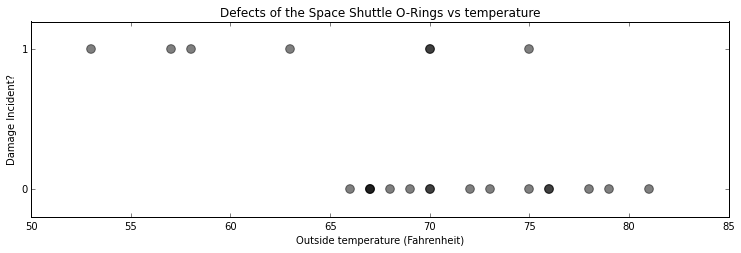

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import numpy as np
figsize(12.5, 4)

figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print "Temp (F), O-Ring failure?"
print challenger_data

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")

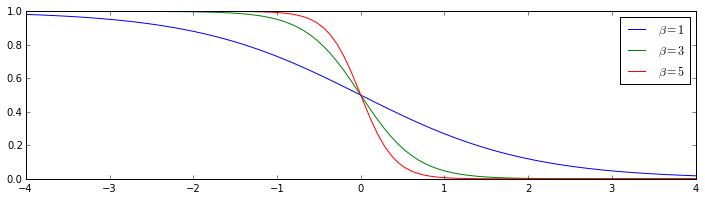

In [2]:
#The purpose of this exercise is to ask
#At Temperature t what is the the probability of incident

#What does a temperature function look like

#This is a logistic function that gives us a probability 
#dependent on the temperature
#p(t) = 1 / (1 + e*(Bt))

figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 +np.exp(beta*x))

x = np.linspace(-4,4,100)
plt.plot(x, logistic(x,1), label=r"$\beta = 1$")
plt.plot(x, logistic(x,3), label=r"$\beta = 3$")
plt.plot(x, logistic(x,5), label=r"$\beta = 5$")
plt.legend();





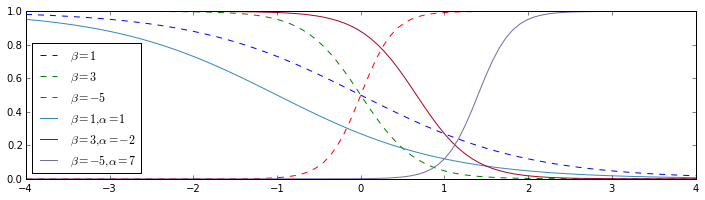

In [3]:
#As we see that our values only change near zero we need to adjust
#for the fact that we know the values only change 
#between 65 and 70 degrees F

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x)+alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

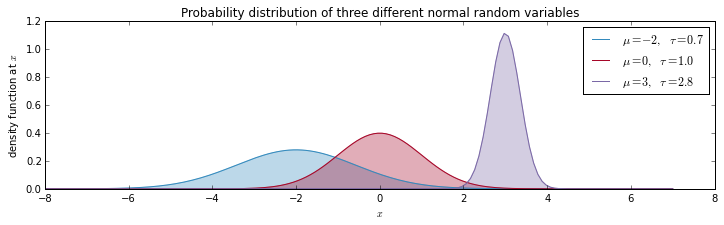

In [5]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x,_mu, scale=1. / _tau),
            label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale= 1. / _tau), color = _color,
                    alpha = .33)

    

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different normal random variables");

In [6]:
#From the above graph we can see that as Tau increases in value
#Our distribution becomes tighter, we have smaller variance
#The reduction in variance is an indicator in certainty with respect 
#To the value of the mean

In [8]:
import pymc as pm

temperature = challenger_data[:,0]
D = challenger_data[:,1]

beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 /(1. +np.exp(beta * t + alpha))



In [9]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

In [19]:
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)
model =pm.Model([observed, beta, alpha])

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000,100000,2)

 [-----------------100%-----------------] 120000 of 120000 complete in 15.9 sec

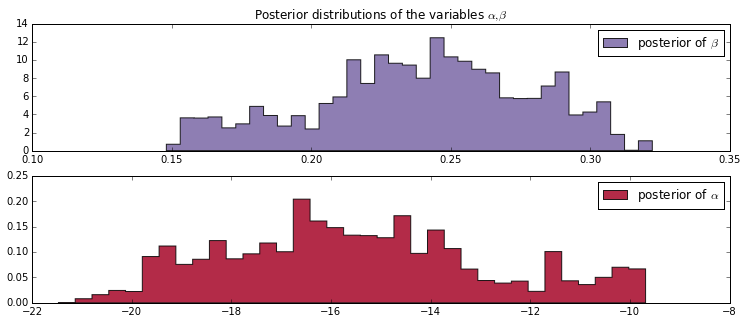

In [28]:
alpha_samples = mcmc.trace('alpha')[:,None] 
beta_samples = mcmc.trace('beta')[:,None]


# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [13]:
#All Beta values are greater than zero, indicating some temperature affect on the outcome
#If temperature values were centered around zero, then we could suspect that temperature has
#little to no affect on the outcome
#The dispersion of the Beta values indicates that we are uncertain of the exact affect 
#temperature on outcome

In [21]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:,None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

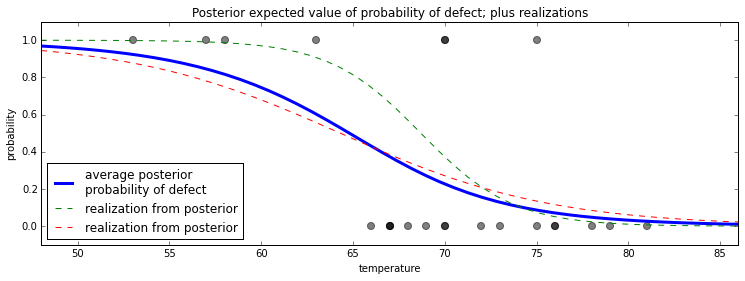

In [22]:
figsize(12.5,4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

#The blue line is the average value of all the possible probabilities at any given temp
#The dotted lines are selected instances from the sample set of possible probabilities at each 
#given temp



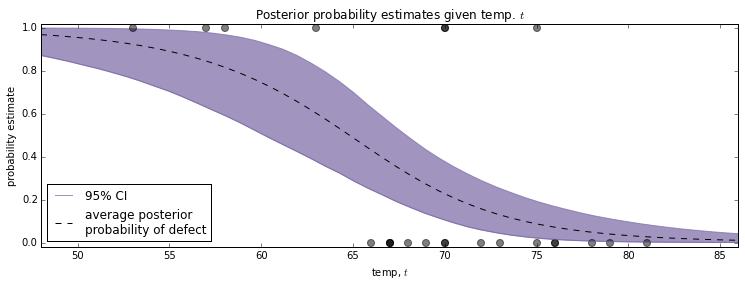

In [23]:
#What happens if we ask at what temperatures are we most uncertain 
#About the affect of temperature on the Oring

from scipy.stats.mstats import mquantiles

#We create confidence interval of 2.5% quantiles around bottome and top

qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:,0], *qs, alpha=0.7,
                color = "#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

In [ ]:
#The purple area represents a 95% credible interval 
#for each temperature. For example at 65 degrees we be 95% sure
#that the probability of defect lies between 25% and 75%

#We can see that the at the tales there is higher confidence 
#within smaller bands of probability. We are more certain
#about the behavior at these temperature extremes
#As temperatures approach the middle near 60 we 
#Become less certain about the probability of defect
#The curve fattens 

#Because our uncertainty is concentrated in the range 60-65
#we should get better estimates of probability in that range

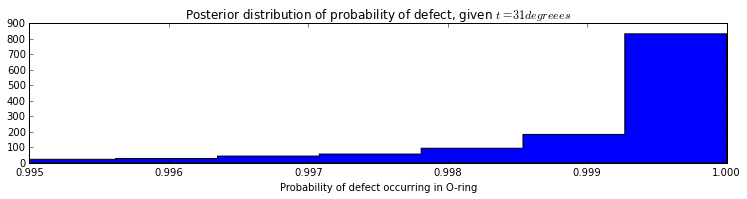

In [25]:
#For the Challenger Disaster the temp was 31 degrees
#We can be very confident that the probability of defect is high

figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=100, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of probability of defect, given $t=31 degreees$")
plt.xlabel("Probability of defect occurring in O-ring")

In [26]:
#How do we know our model is an expression of the data?
#We must find a way to measure goodness of fit

#Is there a way to test if our model is a bad fit?
#We can do so by comparing our observed data with an artificial data set
#The rationale is that if the simulated dataset is not statistically similar
#to our observed dataset, then likely our model 
#does not accurately represent the observed data

#We'll create a new stochastic variable that is 
#similar to the variable that stored our observations
#However, we'll remove our observations

#Previously our observed stochastic var was:

#observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

#We now need to create a simulation of that data
#Recall that p was our stochastic that was a function 
#of temp, Beta and alpha
simulated_data = pm.Bernoulli("simulation_data", p)
N=10000 #number of simulations

mcmc = pm.MCMC([simulated_data, alpha, beta, observed])
mcmc.sample(N)


 [-----------------100%-----------------] 10000 of 10000 complete in 2.2 sec

(10000, 23)


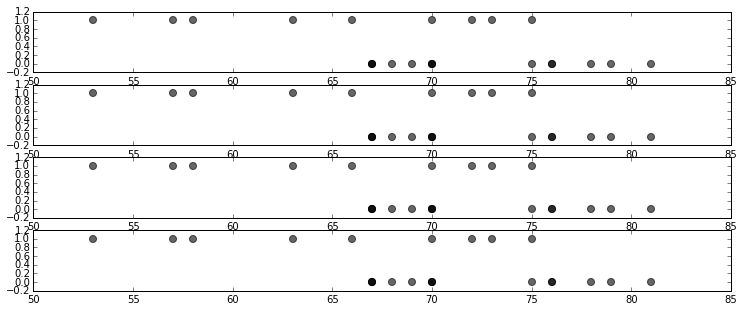

In [32]:
figsize(12.5, 5)

simulations = mcmc.trace("simulation_data")[:]
print simulations.shape


plt.title("Simulated dataset using posterior params")
figsize(12.5,6)

for i in range(4):
    ax = plt.subplot(4,1,i+1)
    plt.scatter(temperature, simulations[1000*1,:], 
                color='k', s=50, alpha=0.6)


In [37]:
#the goodness of fit is determined mostly by a visual inspection
#For logistic regression this is the sufficient and acceptable

#We can also graph plots called separation plots
#For models we wish to compare, each model is plotted
#on an individual separation plot

#For each model we calculate the proportion of times the posterior
#simulation proposed a value of 1 for a particular temperature
#a value of 1 means the computed probability of a defect

#This results in a computed posterior probability of defect at each data
#point in the dataset

posterior_probability = simulations.mean(axis=0)

print "posterior prob of defect | realized defect"
for i in range(len(D)):
    print "%.2f         |   %d" % (posterior_probability[i], D[i])

posterior prob of defect | realized defect
0.43         |   0
0.23         |   1
0.27         |   0
0.32         |   0
0.37         |   0
0.16         |   0
0.13         |   0
0.23         |   0
0.85         |   1
0.59         |   1
0.23         |   1
0.04         |   0
0.38         |   0
0.93         |   1
0.37         |   0
0.08         |   0
0.23         |   0
0.02         |   0
0.07         |   0
0.04         |   0
0.09         |   1
0.07         |   0
0.82         |   1


In [42]:
#Now we sort each column by posterior probabilities

ix = np.argsort(posterior_probability)

print "prob | defect"

for i in range(len(D)):
    print "%.2f  |  %d"% (posterior_probability[ix[i]], D[ix[i]])

prob | defect
0.02  |  0
0.04  |  0
0.04  |  0
0.07  |  0
0.07  |  0
0.08  |  0
0.09  |  1
0.13  |  0
0.16  |  0
0.23  |  0
0.23  |  0
0.23  |  1
0.23  |  1
0.27  |  0
0.32  |  0
0.37  |  0
0.37  |  0
0.38  |  0
0.43  |  0
0.59  |  1
0.82  |  1
0.85  |  1
0.93  |  1


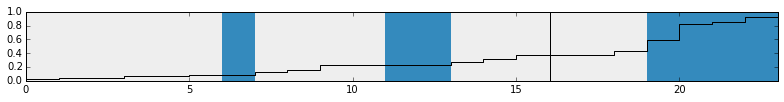

In [45]:
from separation_plot import separation_plot


figsize(11., 1.5)
separation_plot(posterior_probability, D)

#The graph below indicates where we the defects occurred (in blue)
#The thinking is that as the probability of defect increases(black line)
#The defects will be clustered to the right where the highest
#probabilities are located

#the black line is the expected number of defects we should 
#expect given this model. This allows to understand a predicted vs actual
#We can compare this model to other models to see how it performs



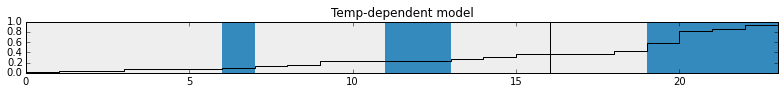

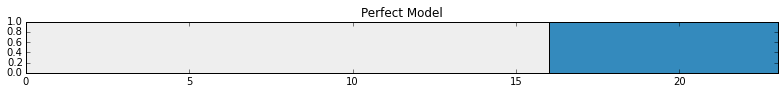

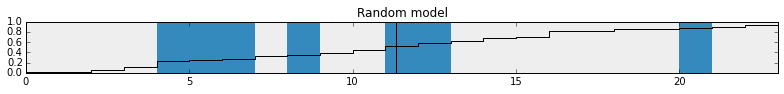

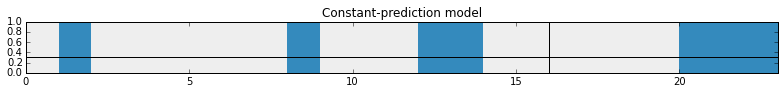

In [46]:
#We'll compare to three other models
#1. A perfect model that predicts 1 if a defect occurs
#2. A completely random model, predicts random prob regardless of temp
#3. A constant model that bases prediction of frequency of defects

figsize(11., 1.25)

separation_plot(posterior_probability, D)
plt.title("Temp-dependent model")

#Perfect model 

p = D
separation_plot(p, D)
plt.title("Perfect Model")

#Random Model
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

#Constant model

constant_prob = 7. / 23 * np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model")

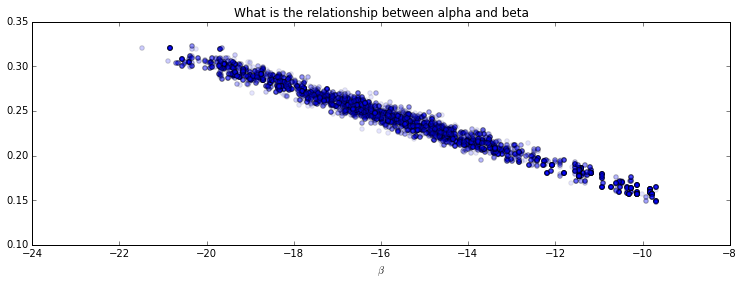

In [47]:
#What is the relationship between beta and alpha
#We can see from the graph that they are inversely correlated
figsize(12.5, 4)

plt.scatter(alpha_samples, beta_samples, alpha=0.1)

plt.title("What is the relationship between alpha and beta")
plt.xlabel(r"$\alpha$")
plt.xlabel(r"$\beta$")
